In [117]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score

## Data preprocessing

In [118]:

train_dir = os.path.join('../models/train')
validation_dir = os.path.join('../models/val')
test_dir = os.path.join('../models/test')
BATCH_SIZE = 12
IMG_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 21998 files belonging to 6 classes.


In [119]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2442 files belonging to 6 classes.


In [120]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 600 files belonging to 6 classes.


Show the first nine images and labels from the training set:

In [121]:
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Print the true labels
print('True Labels:\n', true_labels)

True Labels:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

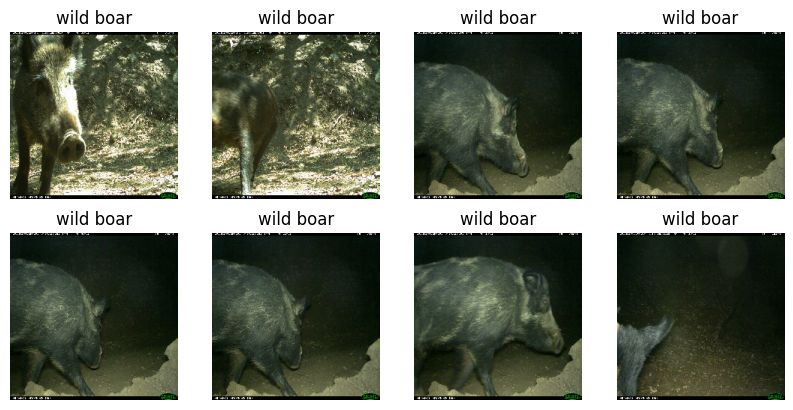

In [122]:
class_labels = ['dear', 'fox','leopard cat','porcupine','sumatran serow', 'wild boar']

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(178):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_labels[labels[i]])
        plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [123]:
val_batches = tf.data.experimental.cardinality(validation_dataset)



In [124]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 204
Number of test batches: 50


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. 

In [125]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [126]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomCrop(224, 224, seed=None, name=None),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, fill_mode='nearest'),
    
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

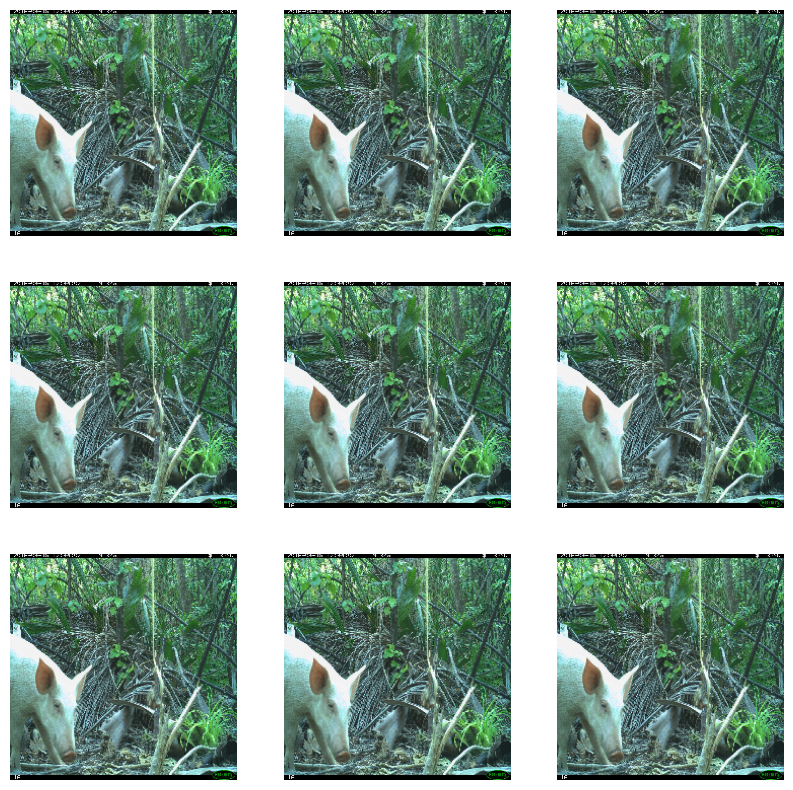

In [127]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [128]:
tf.keras.backend.clear_session()

In [129]:
resize_fn = tf.keras.layers.Resizing(224, 224)

train_dataset= train_dataset.map(lambda x, y: (resize_fn(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (resize_fn(x), y))
test_dataset = test_dataset.map(lambda x, y: (resize_fn(x), y))

In [130]:
augmentation_layers = [
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomCrop(224, 224, seed=None, name=None),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, fill_mode='nearest'),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [131]:
def preprocess(images, labels):
  return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)


In [132]:
# import tensorflow as tf
# from tensorflow.keras.layers import BatchNormalization

# from kerastuner.tuners import RandomSearch
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# def build_model(hp):
#     IMG_SHAPE = IMG_SIZE + (3,)
    
#     # Base MobileNetV2 model
#     base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                    include_top=False,
#                                                    weights='imagenet')
    
#     # Global average pooling layer
#     global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


#     # Input layer
#     inputs = tf.keras.Input(shape=(224, 224, 3))
    
#     # BatchNormalization layer
#     x = BatchNormalization()(inputs)
    
#     # Data augmentation
#     x = data_augmentation(x)
    
#     # Preprocess input
#     x = preprocess_input(x)
    
#     # Base MobileNetV2 model
#     x = base_model(x, training=False)
    
#     # Global average pooling
#     x = global_average_layer(x)
    
#     # Dropout layer with tunable rate
#     dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)
    
#     # Dense prediction layer with L2 regularization
#     l2_reg_strength = hp.Float('l2_reg_strength', min_value=1e-4, max_value=1e-2, sampling='LOG')
#     prediction_layer = tf.keras.layers.Dense(len(class_labels), activation='softmax', name='prediction', 
#                                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg_strength))
#     outputs = prediction_layer(x)
    
#     # Build the model
#     model = tf.keras.Model(inputs, outputs)



#     # Compile the model
#     model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
#                   metrics=['accuracy', 'top_k_categorical_accuracy'], loss='sparse_categorical_crossentropy')
    
#     return model

# # Instantiate the tuner
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,  # Adjust the number of trials as needed
#     directory='keras_tuner_dir',
#     project_name='image_classification')

# # Define a callback to stop training early if there's no improvement
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# # Perform the search for the best hyperparameters
# tuner.search(train_dataset, epochs=9, validation_data=validation_dataset, callbacks=[early_stopping])

# # Get the best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Build the final model with the best hyperparameters
# final_model = tuner.hypermodel.build(best_hps)

In [133]:
# AUTOTUNE = tf.data.AUTOTUNE


# resize_and_rescale = tf.keras.Sequential([
#   tf.keras.layers.Resizing(224, 224),
#   tf.keras.layers.Rescaling(1./255)
# ])

# def prepare(ds, shuffle=False, augment=False):
#   # Resize and rescale all datasets.
#   ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
#               num_parallel_calls=AUTOTUNE)

#   if shuffle:
#     ds = ds.shuffle(1000)



#   # Use data augmentation only on the training set.
#   if augment:
#     ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
#                 num_parallel_calls=AUTOTUNE)

#   # Use buffered prefetching on all datasets.
#   return ds.prefetch(buffer_size=AUTOTUNE)

In [134]:
# train_dataset = prepare(train_dataset, shuffle=True, augment=True)
# validation_dataset = prepare(validation_dataset)
# test_dataset = prepare(test_dataset)

### Rescale pixel values

In [135]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [136]:
# rescale = tf.keras.layers.Rescaling(1./255, offset=-1)


In [137]:
# rescale = tf.keras.layers.Rescaling(1./255, offset=-1)

## Quantization Aware Training Model Architecture

In [138]:
import tensorflow_model_optimization as tfmot

# Helper function uses `quantize_annotate_layer` to annotate that only the 
# Dense layers should be quantized.
#added layers here
last_conv_layers = [
    "block_9_expand",
    "block_9_expand_relu",
    "block_9_depthwise",
    "block_9_depthwise_relu",
    "block_9_project",
    "block_9_add",
    "block_10_expand",
    "block_10_expand_relu",
    "block_10_depthwise",
    "block_10_depthwise_relu",
    "block_10_project",
    "block_10_add",
    "block_11_expand",
    "block_11_expand_relu",
    "block_11_depthwise",
    "block_11_depthwise_relu",
    "block_11_project",
    "block_11_add",
    "block_12_expand",
    "block_12_expand_relu",
    "block_12_depthwise",
    "block_12_depthwise_relu",
    "block_12_project",
    "block_12_add",
    "block_13_expand",
    "block_13_expand_relu",
    "block_13_pad",
    "block_13_depthwise",
    "block_13_depthwise_relu",
    "block_13_project",
    "block_14_expand",
    "block_14_expand_relu",
    "block_14_depthwise",
    "block_14_depthwise_relu",
    "block_14_project",
    "block_14_add",
    "block_15_expand",
    "block_15_expand_relu",
    "block_15_depthwise",
    "block_15_depthwise_relu",
    "block_15_project",
    "block_15_add",
    "block_16_expand",
    "block_16_expand_relu",
    "block_16_depthwise",
    "block_16_depthwise_relu",
    "block_16_project",
    "Conv_1",
    "out_relu"
]
def apply_quantization_to_conv(layer):
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
      return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer
def apply_quantization_to_last_conv(layer):
    if layer.name in last_conv_layers :
      print(layer.name)
      return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [139]:
import tensorflow_model_optimization as tfmot


def get_model(in_shape, qatBaseFull=True, qatConv=True):

    base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                   input_shape=in_shape,
                                                   weights='imagenet')
    base_model.trainable = False


    if qatBaseFull:
        qat_model = tfmot.quantization.keras.quantize_model(base_model)
        return qat_model

    if qatConv:
        # Use `keras.models.clone_model` to apply `apply_quantization_to_dense` 
        # to the layers of the model.
        annotated_model = tf.keras.models.clone_model(
            base_model,
            clone_function=apply_quantization_to_last_conv,
        )
        annotated_model.summary()
        qat_model = tfmot.quantization.keras.quantize_apply(annotated_model)
        return qat_model
    return base_model

In [140]:
base_model = get_model(in_shape=(224, 224, 3), qatBaseFull=False,qatConv=False)

In [141]:
q_base_model = get_model(in_shape=(224, 224, 3), qatBaseFull=False,qatConv=True)

block_9_expand
block_9_expand_relu
block_9_depthwise
block_9_depthwise_relu
block_9_project
block_9_add
block_10_expand
block_10_expand_relu
block_10_depthwise
block_10_depthwise_relu
block_10_project
block_11_expand
block_11_expand_relu
block_11_depthwise
block_11_depthwise_relu
block_11_project
block_11_add
block_12_expand
block_12_expand_relu
block_12_depthwise
block_12_depthwise_relu
block_12_project
block_12_add
block_13_expand
block_13_expand_relu
block_13_pad
block_13_depthwise
block_13_depthwise_relu
block_13_project
block_14_expand
block_14_expand_relu
block_14_depthwise
block_14_depthwise_relu
block_14_project
block_14_add
block_15_expand
block_15_expand_relu
block_15_depthwise
block_15_depthwise_relu
block_15_project
block_15_add
block_16_expand
block_16_expand_relu
block_16_depthwise
block_16_depthwise_relu
block_16_project
Conv_1
out_relu


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[1][0]']                  
                                )                                              

In [142]:
# Get the number of layers
num_layers = len(q_base_model.layers)
print("Number of layers in the model:", num_layers)

Number of layers in the model: 154


In [143]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = q_base_model(image_batch)
print(feature_batch.shape)

(12, 7, 7, 1280)


## Feature extraction
In this step, will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally,add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [144]:
q_base_model.trainable = False

In [145]:
q_base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[1][0]']                  
                                )                                              

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [146]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(12, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [147]:
from tensorflow.keras import regularizers
prediction_layer = tf.keras.layers.Dense(6,activation='softmax',name='prediction',kernel_regularizer=regularizers.l2(0.01))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(12, 6)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [148]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
x = tf.keras.layers.GlobalAveragePooling2D()(q_base_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(q_base_model.input,outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[1][0]']                  
                                )                                                             

In [149]:
# from tensorflow.keras.layers import BatchNormalization

# inputs = tf.keras.Input(shape=(224, 224, 3))
# # add BatchNormalization
# x= BatchNormalization()(inputs)
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = base_model(inputs, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

In [150]:
layer_names = [layer.name for layer in model.layers]
print(layer_names)

['input_2', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_expand_

In [151]:
import tensorflow as tf


# Print layer index and name
for layer_index, layer in enumerate(model.layers):
    print(model.layers)
    print(f"Layer {layer_index}: {layer.name}")

[<keras.engine.input_layer.InputLayer object at 0x00000283D26AF040>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000002839FABF1F0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002839FABF4C0>, <keras.layers.activation.relu.ReLU object at 0x000002839FABEE30>, <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x000002839FABC880>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002839FABDED0>, <keras.layers.activation.relu.ReLU object at 0x000002839FABC250>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000002844D5D2320>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000283C4FD42E0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000002844D5D0C70>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000283C4F91C90>, <keras.layers.activation.relu.ReLU object at 0x0000028447088580>, <keras.layers.reshaping.zero_p

In [152]:
# from tensorflow.keras.layers import BatchNormalization

# inputs = tf.keras.Input(shape=(224, 224, 3))
# #add BatchNormalization
# x= BatchNormalization()(inputs)
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

In [153]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[1][0]']                  
                                )                                                             

In [154]:
# import tensorflow_model_optimization as tfmot

# LastValueQuantizer = tfmot.quantization.keras.quantizers.LastValueQuantizer
# MovingAverageQuantizer = tfmot.quantization.keras.quantizers.MovingAverageQuantizer

# class DefaultDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):

#     # List all of your weights
#     weights = {
#         "kernel": LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False)
#     }

#     # List of all your activations
#     activations = {
#         "activation": MovingAverageQuantizer(num_bits=8, symmetric=False, narrow_range=False, per_axis=False)
#     }

#     # Configure how to quantize weights.
#     def get_weights_and_quantizers(self, layer):
#         output = []
#         for attribute, quantizer in self.weights.items():
#             if hasattr(layer, attribute):
#                 output.append((getattr(layer, attribute), quantizer))

#         return output

#     # Configure how to quantize activations.
#     def get_activations_and_quantizers(self, layer):
#         output = []
#         for attribute, quantizer in self.activations.items():
#             if hasattr(layer, attribute):
#                 output.append((getattr(layer, attribute), quantizer))

#         return output

#     def set_quantize_weights(self, layer, quantize_weights):
#         # Add this line for each item returned in `get_weights_and_quantizers`
#         # , in the same order

#         count = 0
#         for attribute in self.weights.keys():
#             if hasattr(layer, attribute):
#                 setattr(layer, attribute, quantize_weights[count])
#                 count += 1

#     def set_quantize_activations(self, layer, quantize_activations):
#         # Add this line for each item returned in `get_activations_and_quantizers`
#         # , in the same order.
#         count = 0
#         for attribute in self.activations.keys():
#             if hasattr(layer, attribute):
#                 setattr(layer, attribute, quantize_activations[count])
#                 count += 1

#     # Configure how to quantize outputs (may be equivalent to activations).
#     def get_output_quantizers(self, layer):
#       return []

#     def get_config(self):
#       return {}

In [155]:
# class CustomLayer(tf.keras.layers.Layer):
   

# with tfmot.quantization.keras.quantize_scope({
#     "DefaultDenseQuantizeConfig": DefaultDenseQuantizeConfig,
#     "CustomLayer": CustomLayer
# }):
#     def apply_quantization_to_layer(layer):
#       return tfmot.quantization.keras.quantize_annotate_layer(layer, DefaultDenseQuantizeConfig())
    
#     annotated_model = tf.keras.models.clone_model(
#         model,
#         clone_function=apply_quantization_to_layer,
#     )

#     tfmot.quantization.keras.quantize_apply(annotated_model)

In [156]:
# # import tensorflow_model_optimization as tfmot
# import tensorflow as tf

# class WeightClip(tf.keras.constraints.Constraint):
#     """Custom Keras Constraint for doing weight clipping."""
    
#     def __init__(self, min_value, max_value):
#         self.min = min_value
#         self.max = max_value
    
#     def call(self, w):
#         return tf.clip_by_value(w, self.min, self.max)
    
#     def get_config(self):
#         return {'min_clip_value': self.min, 'max_clip_value': self.max}

# custom_objects={'WeightClip':WeightClip}
# with tfmot.quantization.keras.quantize_scope(custom_objects):
#     quan_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_mob)


In [157]:
# quant_aware_model.summary()

In [158]:
q_base_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [159]:
# len(quant_aware_model.trainable_variables)

In [160]:

import tensorflow as tf
import os

# Set the number of parallel execution units
NUM_PARALLEL_EXEC_UNITS = 8

# Configuring TensorFlow Session
config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=1
)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


# MKL and OpenMP
os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1"

In [161]:
model_name = "MobileNetV2_updated"

models_dir = os.path.join('./models')
model_dir = os.path.join(models_dir, model_name)
model_save_dir = os.path.join(model_dir, model_name)
model_save_path = os.path.join(model_save_dir, model_name + "_base.h5")


if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [162]:

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger
# Save the model with best weights
top_layers_file_path = os.path.join(model_save_dir, model_name + "_top_layers.h5")

# Save the model after every epoch.
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
# Save the TensorBoard logs.
tb = TensorBoard(log_dir='./logs', write_graph=True, update_freq='batch')
# Stop training when a monitored metric has stopped improving.
early = EarlyStopping(monitor="loss", mode="min", patience=5)
# Save the CSV logger
csv_logger = CSVLogger('./logs/mobilenetv2-old-log.csv', append=True)

In [163]:
# Check if GPU is available
import tensorflow as tf

devices = tf.config.list_physical_devices('GPU')
print("GPU Devices:", devices)

GPU Devices: []


In [164]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[1][0]']                  
                                )                                                             

In [203]:


from datetime import datetime


def accuracy_loss_plot(history, model_config):
    epochs = history.epoch
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    run_epochs = len(epochs)

    f = 1
    save_epochs = [epochs[i] for i in range(0, run_epochs, f)]
    save_tr_acc = [tr_acc[i] for i in range(0, run_epochs, f)]
    save_tr_loss = [tr_loss[i] for i in range(0, run_epochs, f)]
    save_val_acc = [val_acc[i] for i in range(0, run_epochs, f)]
    save_val_loss = [val_loss[i] for i in range(0, run_epochs, f)]

    # Create a figure and axis
    fig, ax1 = plt.subplots()

    fig.set_figheight(12)
    fig.set_figwidth(24)

    # Plot accuracy lines
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='black')
    ax1.plot(save_epochs, save_tr_acc, color='#800000', marker='o', label='Training Accuracy')
    ax1.plot(save_epochs, save_val_acc, color='#000075', marker='x', label='Validation Accuracy')
    # ax1.set_xticklabels(save_epochs, rotation=90)

    # Create a second y-axis for loss lines
    ax2 = ax1.twinx()  # Share the same x-axis
    ax2.set_ylabel('Loss', color='black')
    ax2.plot(save_epochs, save_tr_loss, color='#3cb44b', marker='s', label='Training Loss')
    ax2.plot(save_epochs, save_val_loss, color='#f58231', marker='^', label='Validation Loss')
    ax2.tick_params(axis='y', labelcolor='black')

    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    # Set a title
    plt.title('Accuracy and Loss Over Epochs')
    roc_auc_path = os.path.join(os.getcwd(), f'./metrics/{model_name}/roc_auc')

    accuracy_matrices_path = os.path.join(os.getcwd(), f'./metrics/{model_name}/accuracy_matrices')

    curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    filename = f'{model_name.lower()}-{model_config}-training_metrics_plot-{format(curr_datetime)}.png'

    if not os.path.exists(accuracy_matrices_path):
        os.makedirs(accuracy_matrices_path)

    # Save the plot to the specified folder
    destination = os.path.join(accuracy_matrices_path, filename)
    plt.savefig(destination, bbox_inches='tight')

### Compile the model

In [166]:
base_learning_rate = 0.0001

model. compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='sparse_categorical_crossentropy')


### Train the model


In [167]:
initial_epochs = 20
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


1834/1834 [==============================] - 1714s 927ms/step - loss: 0.4419 - accuracy: 0.8808 - top_k_categorical_accuracy: 0.7833 - val_loss: 0.1524 - val_accuracy: 0.9730 - val_top_k_categorical_accuracy: 0.5074
Epoch 2/20
1834/1834 [==============================] - 2097s 1s/step - loss: 0.1857 - accuracy: 0.9595 - top_k_categorical_accuracy: 0.7339 - val_loss: 0.0833 - val_accuracy: 0.9881 - val_top_k_categorical_accuracy: 0.6626
Epoch 3/20
1834/1834 [==============================] - 1860s 1s/step - loss: 0.1259 - accuracy: 0.9729 - top_k_categorical_accuracy: 0.7605 - val_loss: 0.0866 - val_accuracy: 0.9816 - val_top_k_categorical_accuracy: 0.7830
Epoch 4/20
1834/1834 [==============================] - 1792s 976ms/step - loss: 0.1051 - accuracy: 0.9759 - top_k_categorical_accuracy: 0.8159 - val_loss: 0.0660 - val_accuracy: 0.9832 - val_top_k_categorical_accuracy: 0.7265
Epoch 5/20
1834/1834 [==============================] - 2148s 1s/step - loss: 0.0867 - accuracy: 0.9781 - top

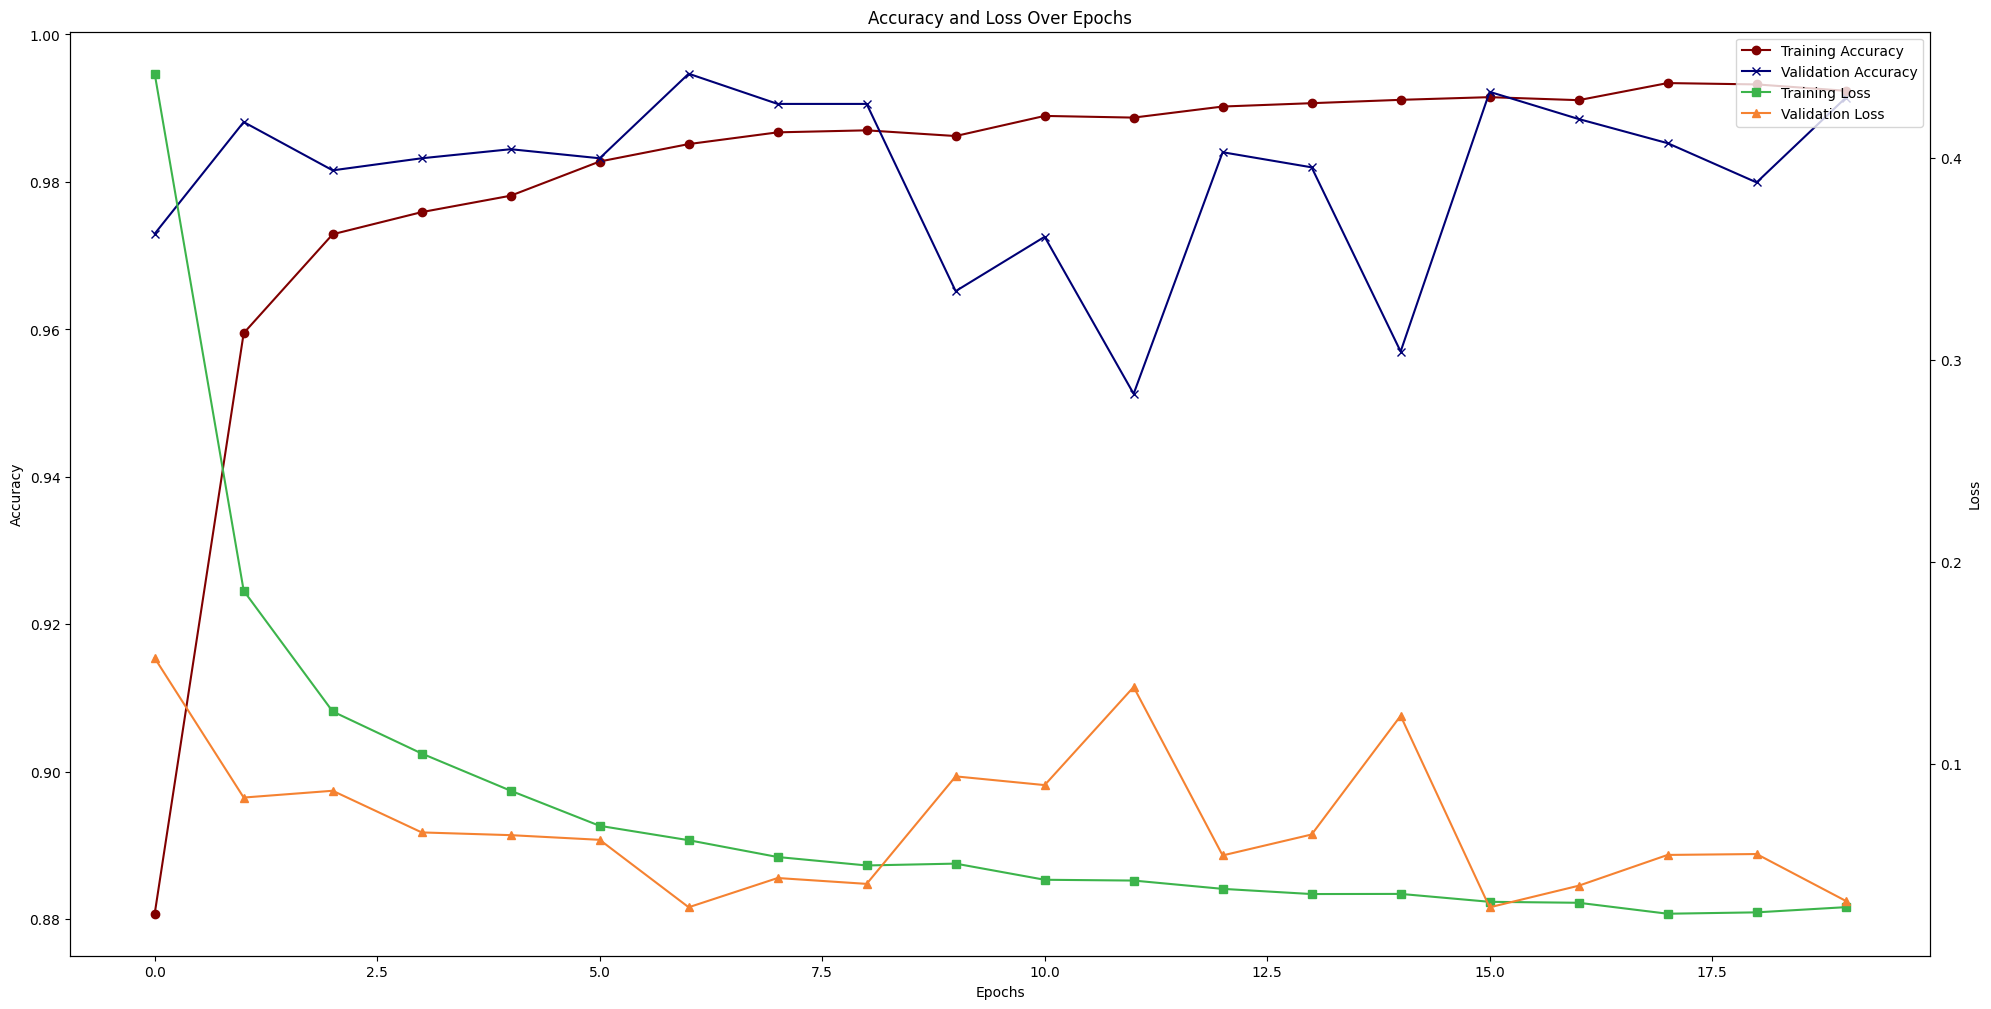

In [168]:
accuracy_loss_plot(history, 'without_tuning')

In [169]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(acc)
print(val_acc)


[0.8807618618011475, 0.9594963192939758, 0.9729066491127014, 0.9759069085121155, 0.9781343936920166, 0.9827711582183838, 0.985135018825531, 0.9867260456085205, 0.9869987964630127, 0.9862260222434998, 0.9889535307884216, 0.9887262582778931, 0.9902263879776001, 0.990680992603302, 0.9911355376243591, 0.9914992451667786, 0.9910901188850403, 0.9934085011482239, 0.9932266473770142, 0.992362916469574]
[0.9729729890823364, 0.9881244897842407, 0.9815725088119507, 0.9832105040550232, 0.984438955783844, 0.9832105040550232, 0.9946764707565308, 0.9905815124511719, 0.9905815124511719, 0.965192437171936, 0.9725634455680847, 0.9512694478034973, 0.9840294718742371, 0.9819819927215576, 0.9570024609565735, 0.9922195076942444, 0.9885339736938477, 0.9852579832077026, 0.9799344539642334, 0.9914004802703857]


In [170]:
#evaluating the model
accuracy = model.evaluate(validation_dataset)

204/204 [==============================] - 100s 479ms/step - loss: 0.0321 - accuracy: 0.9914 - top_k_categorical_accuracy: 0.8812


In [171]:
accuracy = model.evaluate(test_dataset)

50/50 [==============================] - 24s 396ms/step - loss: 1.0686 - accuracy: 0.8083 - top_k_categorical_accuracy: 0.9300


In [172]:

print("initial accuracy: {:.2f}".format(accuracy[1]))

initial accuracy: 0.81


### Learning curves

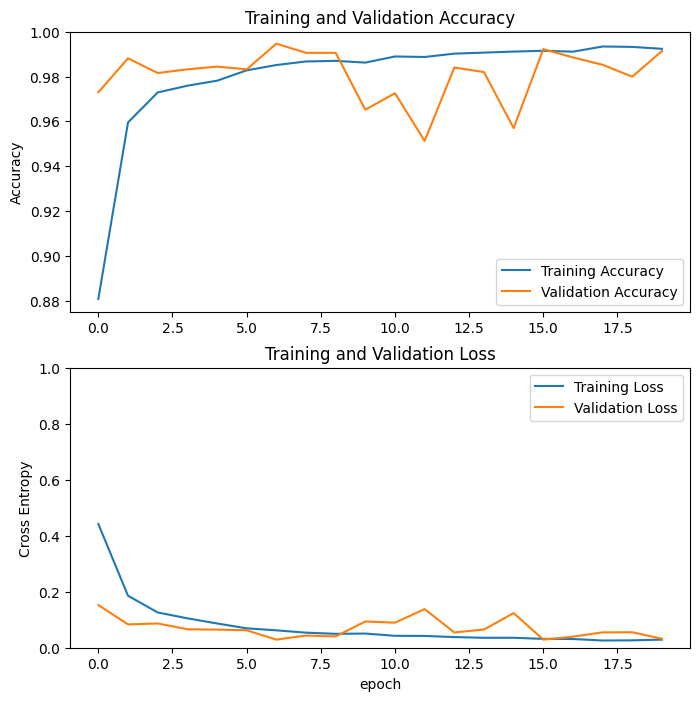

In [173]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [174]:
# Print all weights of the layers with layer name and number
for i, layer in enumerate(model.layers):
    print(f"Layer {i + 1} - Name: {layer.name}")
    weights = layer.get_weights()
    if weights:
        print("Weights:")
        for w in weights:
            print(w)
    else:
        print("No weights")
    print()

Layer 1 - Name: input_2
No weights

Layer 2 - Name: Conv1
Weights:
[[[[-1.71659231e-01 -3.33731920e-01  5.30122258e-02 -5.93232973e-21
     2.08742931e-01 -1.20433941e-01  1.75700430e-02 -3.10708203e-22
    -9.62498877e-03  1.90229788e-01 -3.67278278e-01  3.95997976e-22
    -2.36236629e-22  3.36706383e-22  8.83555040e-02 -7.75416642e-02
     3.95842289e-05 -3.63377742e-02  5.99925742e-02  5.53736472e-21
    -4.68022423e-04 -1.23387486e-01 -1.34351701e-01  8.75968020e-03
    -2.47503355e-01  1.58492010e-02 -2.43145856e-04 -1.09811597e-01
     5.55126644e-22 -2.03368161e-03  2.83311605e-01  7.66634047e-02]
   [-3.18941772e-01 -6.09864295e-01 -1.70770675e-01 -6.76705635e-21
    -5.82342505e-01 -2.56068230e-01 -4.18974347e-02  1.32427304e-22
     2.00757684e-04  3.29488933e-01 -4.01886106e-01  3.63034420e-22
     1.64733595e-22  1.97648923e-22  9.94425565e-02 -1.17755957e-01
     5.50664954e-05 -5.31860851e-02 -2.15648204e-01  3.16011650e-21
     8.09127018e-02  7.85512850e-02 -2.84253448e

In [175]:
q_base_model.trainable = True

In [176]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = len(q_base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in q_base_model.layers[:fine_tune_at]:
  layer.trainable = False
model.summary()
  

Number of layers in the base model:  154
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[1][0]']                  
                                )                    

In [177]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = q_base_model(image_batch)
print(feature_batch.shape)

(12, 7, 7, 1280)


### Compile the model

In [178]:

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy', 'top_k_categorical_accuracy'])


In [179]:


# Summary of the quantization-aware model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[1][0]']                  
                                )                                                             

In [180]:
len(model.trainable_variables)

80

### Continue training the model

In [181]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40
1834/1834 [==============================] - 1617s 871ms/step - loss: 0.2407 - accuracy: 0.9354 - top_k_categorical_accuracy: 0.9089 - val_loss: 0.0372 - val_accuracy: 0.9889 - val_top_k_categorical_accuracy: 0.7944
Epoch 21/40
1834/1834 [==============================] - 1805s 983ms/step - loss: 0.1182 - accuracy: 0.9690 - top_k_categorical_accuracy: 0.8666 - val_loss: 0.0357 - val_accuracy: 0.9898 - val_top_k_categorical_accuracy: 0.7797
Epoch 22/40
1834/1834 [==============================] - 1795s 977ms/step - loss: 0.0903 - accuracy: 0.9752 - top_k_categorical_accuracy: 0.8555 - val_loss: 0.0322 - val_accuracy: 0.9947 - val_top_k_categorical_accuracy: 0.7973
Epoch 23/40
1834/1834 [==============================] - 1789s 974ms/step - loss: 0.0728 - accuracy: 0.9823 - top_k_categorical_accuracy: 0.8536 - val_loss: 0.0292 - val_accuracy: 0.9951 - val_top_k_categorical_accuracy: 0.8088
Epoch 24/40
1834/1834 [==============================] - 1490s 811ms/step - loss: 0.0677

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


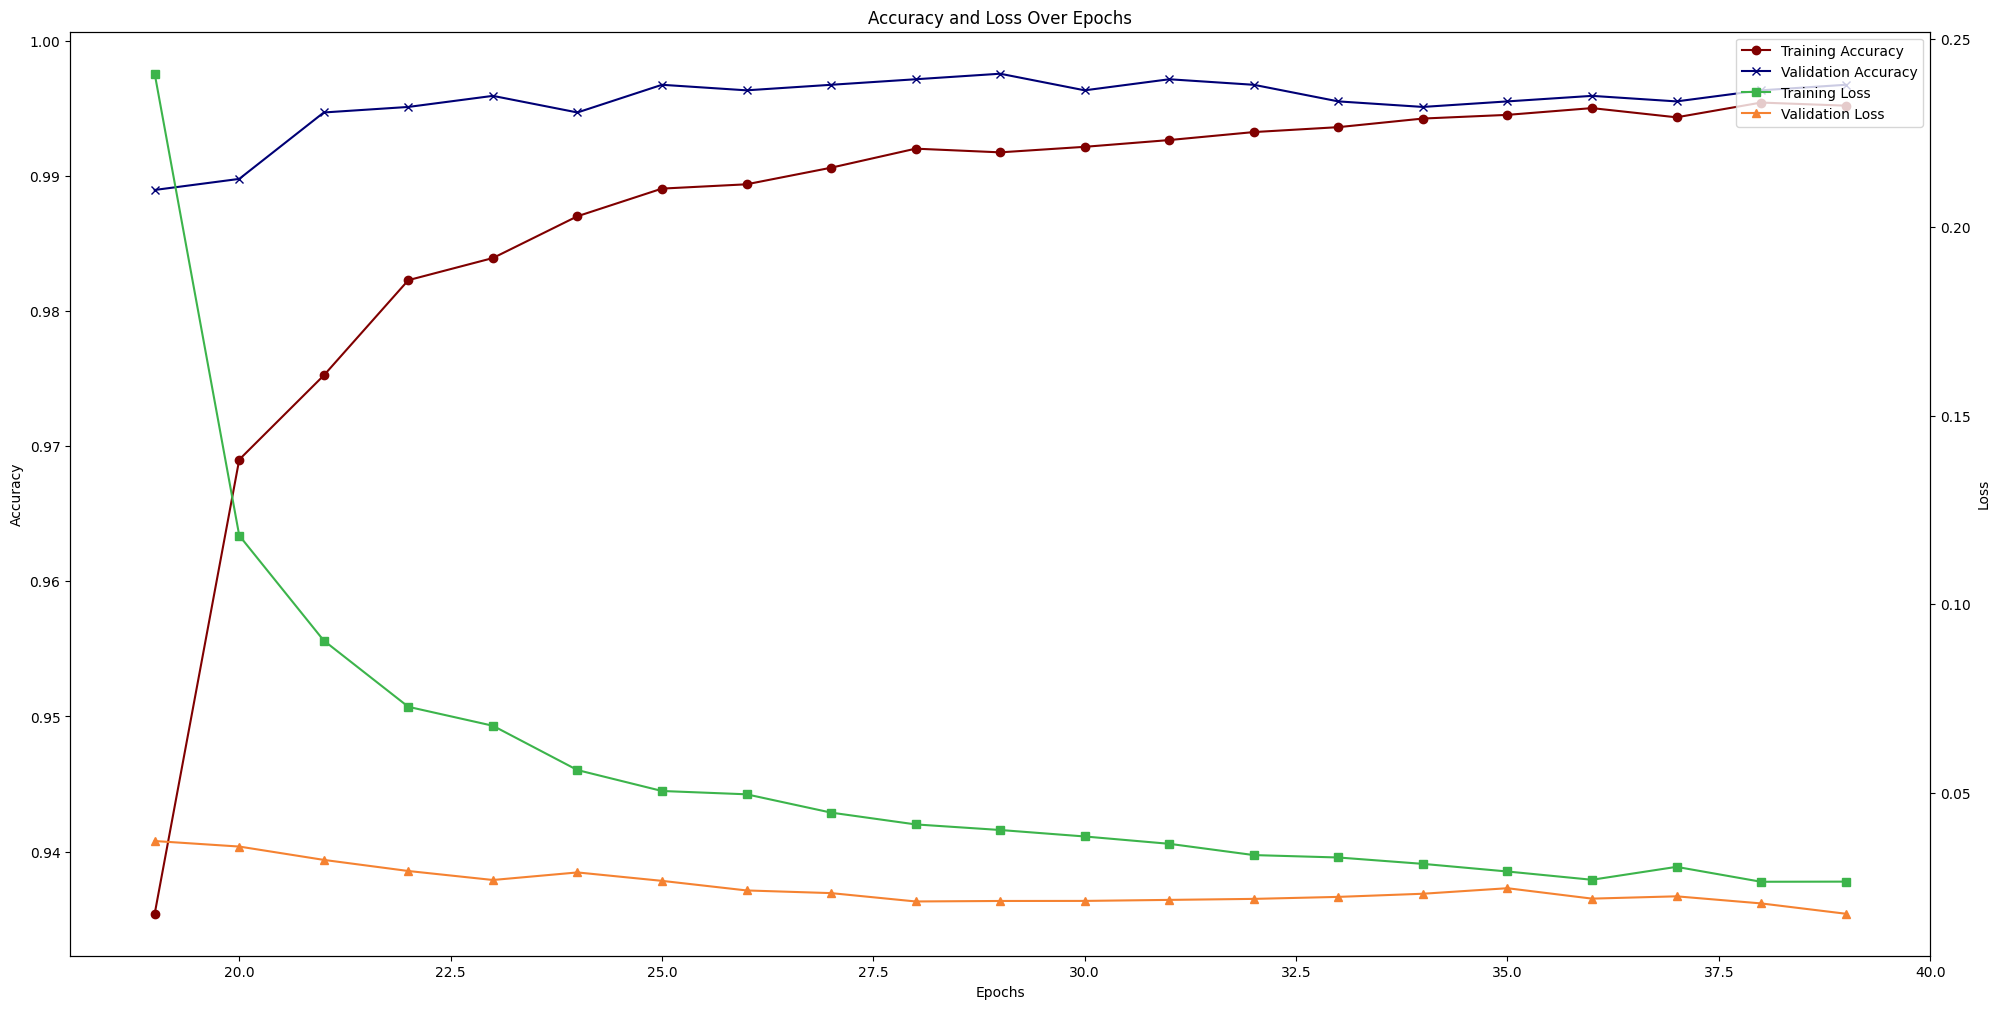

In [204]:
accuracy_loss_plot(history_fine, 'with_tuning')

In [206]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

TypeError: unsupported operand type(s) for +=: 'float' and 'list'

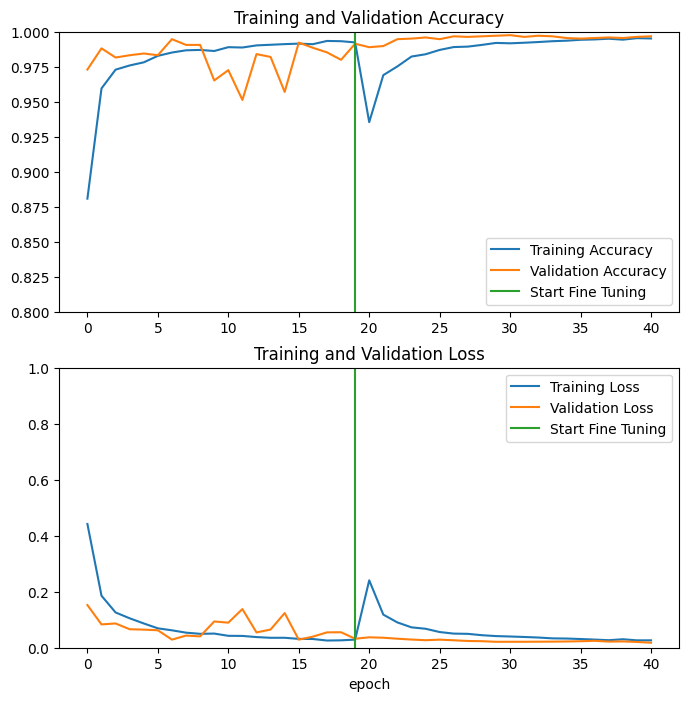

In [184]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [185]:
accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy[1])

50/50 [==============================] - 24s 455ms/step - loss: 0.5054 - accuracy: 0.8467 - top_k_categorical_accuracy: 0.9350
Test accuracy : 0.846666693687439


In [186]:
# Get the predictions for the test data
predictions = model.predict(test_dataset)

50/50 [==============================] - 39s 467ms/step


Predicted Classes:
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 5 0 5 5 4 4 4 4 4 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 5
 5 5 1 5 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 5 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 0 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 

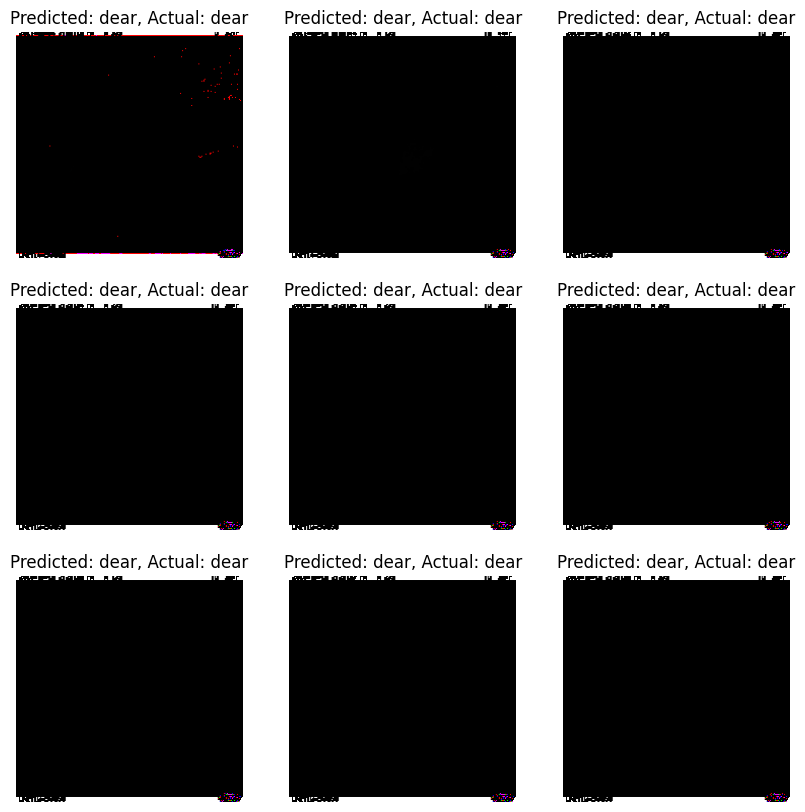

In [196]:

# Apply argmax to get the predicted class
predicted_classes = tf.argmax(predictions, axis=1)


print('Predicted Classes:\n', predicted_classes.numpy())
print('True Classes:\n', np.array(true_labels))

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'Predicted: {class_labels[predicted_classes[i]]}, Actual: {class_labels[labels[i]]}')
    plt.axis("off")


In [197]:

from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score


acc = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='macro')
recall = recall_score(true_labels, predicted_classes, average='macro')
f1 = f1_score(true_labels, predicted_classes, average='macro')

metrics_path = os.path.join(os.getcwd(), './metrics/metric_values')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{model_name}-metrics-{format(curr_datetime)}.txt'

if not os.path.exists(metrics_path):
    os.makedirs(metrics_path)

file_path = os.path.join(metrics_path, filename)
with open(file_path, 'w') as file:
    file.write(f'Accuracy: {acc:.3f}\n')
    file.write(f'Precision: {precision:.3f}\n')
    file.write(f'Recall: {recall:.3f}\n')
    file.write(f'F1 Score: {f1:.3f}\n')
  
print(f'Accuracy: {acc:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

Accuracy: 0.847
Precision: 0.888
Recall: 0.847
F1 Score: 0.832


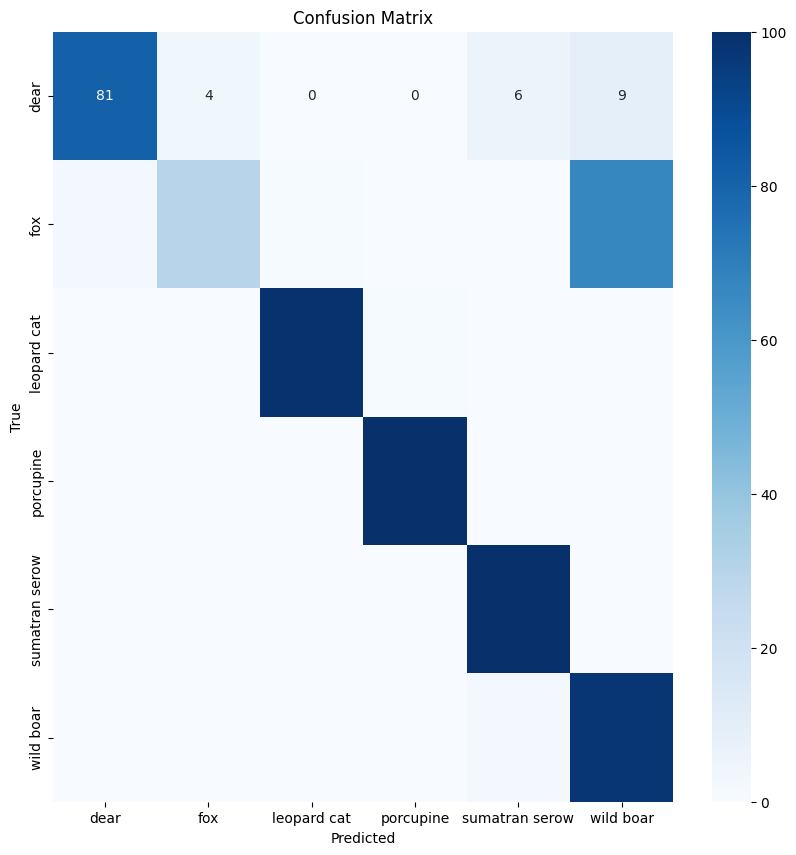

In [199]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix_res = confusion_matrix(true_labels, predicted_classes)


plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix_res, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

confusion_matrix_path = os.path.join(os.getcwd(), './metrics_mobilnet/confusion_matrices')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{"mobilnetv2-QAT_CONV_FINAL"}-confusion_matrix-{format(curr_datetime)}.png'

if not os.path.exists(confusion_matrix_path):
    os.makedirs(confusion_matrix_path)

# Save the plot to the specified folder
save_path = os.path.join(confusion_matrix_path, filename)
plt.savefig(save_path, bbox_inches='tight')

In [200]:
from datetime import datetime
from itertools import cycle
from sklearn.calibration import label_binarize
from sklearn.metrics import auc, roc_curve

model_name = 'MobileNetV2_QAT_FINAL_CONV'
num_labels=6

def get_ROC_AUC(y_pred, y_target):
    # Binarize the labels
    n_classes = num_labels
    true_labels_bin = label_binarize(y_target, classes=range(n_classes))
    predicted_labels_bin = label_binarize(y_pred, classes=range(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        print()
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i],drop_intermediate=True)
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

def save_ROC_AUC(fpr, tpr, roc_auc):
    n_classes = num_labels

    # Plot ROC curves for each class
    plt.figure(figsize=(12, 12))

    hex_colors = [
        "#FF0000",  # Red
        "#00FF00",  # Green
        "#0000FF",  # Blue
        "#FFFF00",  # Yellow
        "#FF00FF",  # Magenta
        "#00FFFF",  # Cyan
        "#FFA500",  # Orange
        "#FF4500",  # OrangeRed
        "#FFD700",  # Gold
        "#8A2BE2",  # BlueViolet
        "#7FFF00",  # Chartreuse
        "#DC143C",  # Crimson
        "#48D1CC",  # MediumTurquoise
        "#2E8B57",  # SeaGreen
        "#800080",  # Purple
        "#ADFF2F",  # GreenYellow
        "#FF1493",  # DeepPink
        "#9370DB",  # MediumPurple
        "#8B4513",  # SaddleBrown
        "#20B2AA",  # LightSeaGreen
        "#8B008B",  # DarkMagenta
        "#FF6347",  # Tomato
        "#556B2F",  # DarkOliveGreen
        "#6B8E23",  # OliveDrab
        "#BDB76B",  # DarkKhaki
        "#808080",  # Gray
        "#DAA520",  # GoldenRod
    ]

    colors = cycle(hex_colors)  # Adjust as needed for your number of classes

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{class_labels[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve and AUC')
    plt.legend(loc='lower right')

    roc_auc_path = os.path.join(os.getcwd(), f'./metrics/{model_name}/roc_auc')

    curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    filename = f'{model_name.lower()}-roc_auc-{format(curr_datetime)}.png'

    if not os.path.exists(roc_auc_path):
        os.makedirs(roc_auc_path)

    # Save the plot to the specified folder
    save_path = os.path.join(roc_auc_path, filename)
    plt.savefig(save_path, bbox_inches='tight')

In [201]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes.numpy(),target_names = class_labels))

                precision    recall  f1-score   support

          dear       0.98      0.81      0.89       100
           fox       0.88      0.30      0.45       100
   leopard cat       0.99      0.99      0.99       100
     porcupine       0.99      1.00      1.00       100
sumatran serow       0.93      1.00      0.96       100
     wild boar       0.56      0.98      0.72       100

      accuracy                           0.85       600
     macro avg       0.89      0.85      0.83       600
  weighted avg       0.89      0.85      0.83       600



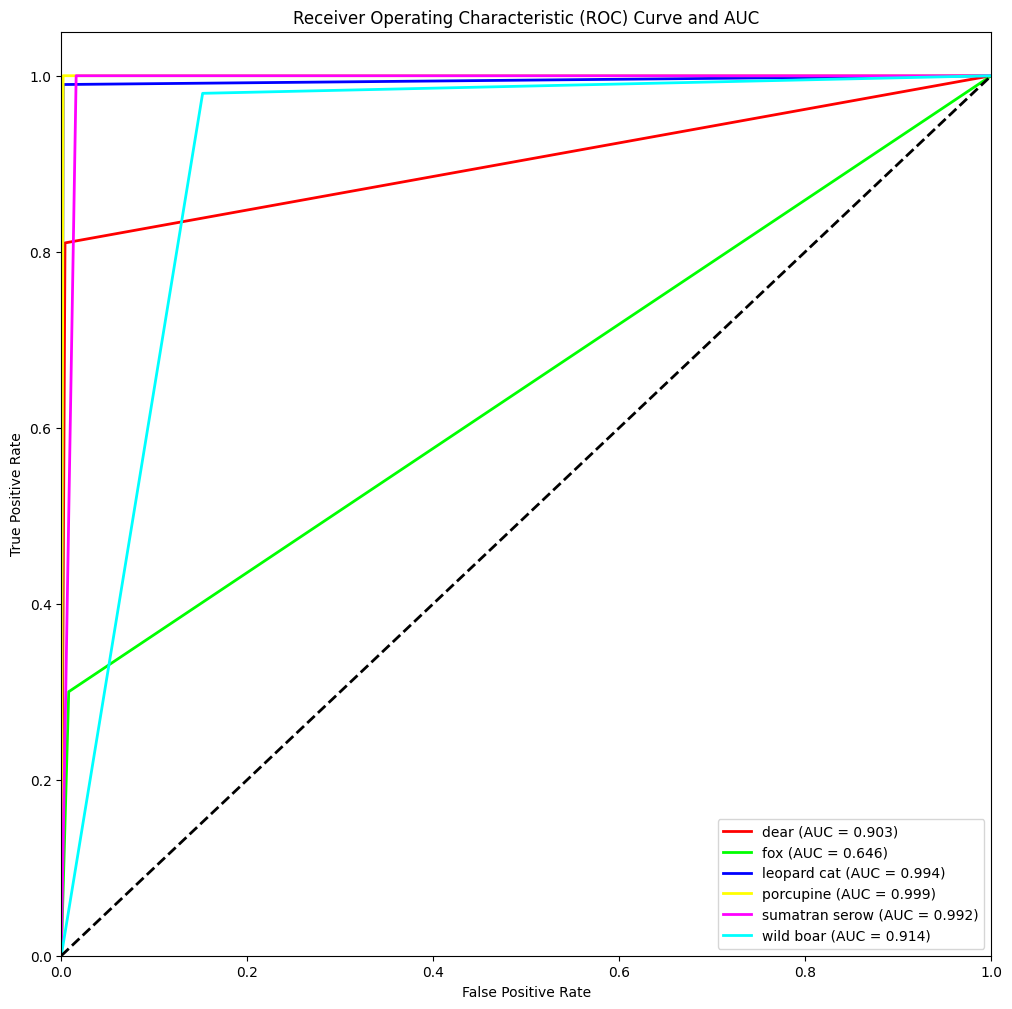

In [202]:
fpr, tpr, roc_auc = get_ROC_AUC(predicted_classes, true_labels)
save_ROC_AUC(fpr, tpr, roc_auc)

In [194]:
#save weights of the trained model to the specified folder
model.save_weights(os.path.join(model_save_dir, model_name + "_weights.h5"))

In [195]:
#save model to the specified folder
model.save(os.path.join(model_save_dir, model_name + ".h5"))

In [208]:
model_size_bytes = os.path.getsize(os.path.join(model_save_dir, model_name + ".h5"))
model_size_megabytes = model_size_bytes / (1024 * 1024)  # Convert bytes to megabytes

print("Model size: {:.2f} megabytes".format(model_size_megabytes))

Model size: 17.36 megabytes


# Create quantized model for TFLite backend

In [214]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

Exception ignored in: <function UniquePtr.__del__ at 0x0000028395FAA4D0>
Traceback (most recent call last):
  File "c:\Users\Dinuka Thathsara\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
AttributeError: 'ScopedTFGraph' object has no attribute '_obj'


INFO:tensorflow:Assets written to: C:\Users\DINUKA~1\AppData\Local\Temp\tmp7m_i8sq1\assets


INFO:tensorflow:Assets written to: C:\Users\DINUKA~1\AppData\Local\Temp\tmp7m_i8sq1\assets
c:\Users\Dinuka Thathsara\anaconda3\envs\myenv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [216]:
# Save the quantized TFLite model to a file
tflite_models_dir = os.path.join(os.getcwd(), 'tflite_models')
tflite_model_dir = os.path.join(tflite_models_dir, model_name)
if not os.path.exists(tflite_model_dir):
    os.makedirs(tflite_model_dir)

tflite_model_save_path = os.path.join(tflite_model_dir, model_name + ".tflite")
with open(tflite_model_save_path, 'wb') as f:
    f.write(quantized_tflite_model)

In [217]:
# Get the size of the TFLite model in megabytes
tflite_model_size_bytes = len(quantized_tflite_model)
tflite_model_size_mb = tflite_model_size_bytes / (1024 * 1024)  # Convert bytes to megabytes
print("Size of the TFLite model:", tflite_model_size_mb, "MB")

Size of the TFLite model: 4.828651428222656 MB


# Inference Process

In [221]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Open image and resize
img_path = './Random_outside_predictions/malayan-porcupine_1497.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0  # Normalize pixel values to be between 0 and 1

# Load the model
# general_model = tf.keras.models.load_model('models/MobileNetV2_updated/MobileNetV2_updated/MobileNetV2_QAT_FINAL_CONV.h5')
interpreter = tf.lite.Interpreter(model_path='./tflite_models/MobileNetV2_QAT_FINAL_CONV/MobileNetV2_QAT_FINAL_CONV.tflite')
interpreter.allocate_tensors()  # Allocate tensors

# # Make predictions
# predictions = model.predict(img_array)
# # pred_prob = model.predict_proba(test_dataset)
# print(predictions)

# # Get the index of the highest probability class
# predicted_class_index = np.argmax(predictions, axis=1)
# print("Predicted label from general model:",class_labels[predicted_class_index[0]])

# Perform inference
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Post-process the output
predicted_class_index = np.argmax(output_data)

print("Predicted label from Tflite model:",class_labels[predicted_class_index])

Predicted label from Tflite model: porcupine


In [223]:
fpr, tpr, roc_auc = get_ROC_AUC(predicted_class_index, true_labels)
save_ROC_AUC(fpr, tpr, roc_auc)

InvalidParameterError: The 'y' parameter of label_binarize must be an array-like. Got 3 instead.

In [218]:
from sklearn.metrics import classification_report


#load tf lite model and want to calculate accuracy of the compressed model
interpreter = tf.lite.Interpreter(model_path='./tflite_models/MobileNetV2_QAT_FINAL_CONV/MobileNetV2_QAT_FINAL_CONV.tflite')

true_labels = true_labels
predicted_labels = []

for images, labels in test_dataset:
    for image in images:
        image = tf.expand_dims(image, axis=0)
        interpreter.allocate_tensors()
        interpreter.set_tensor(interpreter.get_input_details()[0]['index'], image)
        interpreter.invoke()
        preds = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
        preds = np.argmax(preds, axis=1)
        predicted_labels.extend(preds)

print(classification_report(true_labels, predicted_labels, target_names=class_labels))

                precision    recall  f1-score   support

          dear       0.98      0.80      0.88       100
           fox       0.86      0.30      0.44       100
   leopard cat       0.98      1.00      0.99       100
     porcupine       1.00      1.00      1.00       100
sumatran serow       0.93      1.00      0.96       100
     wild boar       0.57      0.98      0.72       100

      accuracy                           0.85       600
     macro avg       0.88      0.85      0.83       600
  weighted avg       0.88      0.85      0.83       600

